# Tensor Decomposition of Spiking Activity Through Trials
In several previous notebooks, we've utilized the **Spike Matrix** for analysis. As mentioned in [Visualizing Unit Spikes](../visualization/visualize_unit_spikes.ipynb), the Spike Matrix is a 3D matrix (or more precisely, a tensor) with dimensions `neurons`, `time`, and `trials`. Using the neuron spike trains and stimulus table from an NWB file, we can produce a spike matrix for a particular selection of neurons and stimulus trials. The paper [{cite}`Williams2018`](https://www.biorxiv.org/content/10.1101/2020.03.02.974014v3.full.pdf) discusses **TCA**, a method for decomposing such a 3D spike matrix to yield *components* which isolate a set of features from the data. Each component consists of the three vectors called *neuronal factors*, *temporal factors*, and *trial factors*. In concert, these factors show a relationship between weighted populations of cells, their activity during the trials, and activity between trials. In contrast to PCA, TCA can be used to identify trends in neuron activity within trials as well as *across* trials. We do not aim to cover all uses of TCA, but rather help build a concrete intuition on how TCA can be used and pro and cons of this approach. The repo used for this is **[TensorTools](https://github.com/neurostatslab/tensortools/tree/9d1edd8267e404850b5a1472b8fff4eabb9f3a8e/tensortools)**

In this notebook, we demonstrate the simple usage of TCA and how it can be applied to our NWB files. First, cells are selected based on brain region and other criteria, then trials are selected based on repeats of specific trial movies. After this, the spike matrix is produced, and finally TCA produces decomposed factors and plots are generated to interpret them.

### Environment Setup

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import os
import tensortools as tt
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

### Download File
For this notebook, the example file we use is from the Allen Institute's **Visual Coding - Neuropixels** dataset. As long as the NWB file you choose has a properly formatted stimulus table and units table, this code should work.

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-717038285/sub-717038285_ses-732592105.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.56.2) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Selecting Units
To get more interesting factors, it may be of interest to just analyze a subset of Neurons of the NWB's `Units` table. The helper function `get_unit_locations` is made from the `Electrodes` table to select units based on their brain region, and the possible brain regions to select from are printed. Here, units are selected from the regions `VISp`. `VISl`, and `VISpm`, and (for later purposes) the *number* of neurons in each region is recorded to `n_neurons_in_region`. To select units based on other criteria, you can write your own code in the cell below that begins with "selecting units spike times".

In [5]:
units = nwb.units
units[:10]

,velocity_below,amplitude_cutoff,repolarization_slope,snr,firing_rate,waveform_duration,presence_ratio,isi_violations,cumulative_drift,spread,...,d_prime,cluster_id,amplitude,waveform_halfwidth,local_index,silhouette_score,nn_miss_rate,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
915957951,-0.343384,0.000886,0.880810,4.800479,2.035908,0.686767,0.98,0.000000,53.49,50.0,...,6.214486,323,234.454545,0.137353,314,0.229600,0.000102,"[58.4338983925338, 68.84436108646727, 69.12766...","[0.00035119779048895465, 0.0003151291869021440...","[[0.0, 0.2250300000000216, 2.9977350000000555,..."
915957946,0.000000,0.000217,0.400703,3.429461,5.738931,0.714238,0.99,0.009670,123.55,50.0,...,6.316538,322,138.920730,0.151089,313,0.158374,0.000906,"[1.021669806312146, 1.1772369117243047, 2.5084...","[0.00016757406732947436, 0.0001720397921770987...","[[0.0, -3.2106749999999806, 3.150420000000011,..."
915957691,-1.103733,0.014154,0.426480,1.919786,2.008079,0.796650,0.99,2.705249,290.95,100.0,...,3.662792,275,147.761055,0.206030,268,0.158752,0.001013,"[0.6530354333202749, 3.2586094484803794, 3.264...","[7.60907503923193e-05, 7.957109416173626e-05, ...","[[0.0, -11.971440000000083, -12.44139000000006..."
915957685,-0.956569,0.000230,0.842665,4.186323,4.709665,0.837856,0.99,0.005385,53.80,90.0,...,5.161656,274,260.690625,0.192295,267,0.234811,0.000138,"[1.2490037807948806, 1.2540371283237506, 1.831...","[0.000266164371359917, 0.0002605838430779542, ...","[[0.0, -5.997810000000001, 5.6064450000000186,..."
915956513,0.343384,0.500000,0.562422,3.457604,2.181748,0.645561,0.99,0.209098,139.54,60.0,...,2.918675,43,221.177190,0.247236,43,0.057446,0.003356,"[3.2777428357755536, 11.522366088064498, 12.26...","[0.000144906487588058, 0.00010868803407731714,...","[[0.0, 0.0228149999999836, 2.534804999999988, ..."
915956508,1.030151,0.000004,0.958932,5.408729,6.252715,0.494472,0.99,0.001018,30.54,50.0,...,6.895246,42,322.610340,0.192295,42,0.212086,0.002584,"[14.719841772563301, 22.41733014843588, 30.700...","[0.0002151604191262871, 0.00020362049040077184...","[[0.0, 7.416434999999929, 3.2403149999999847, ..."
915956502,-1.030151,0.001222,0.513393,3.237491,16.870943,0.563149,0.99,0.031472,83.51,40.0,...,4.833891,41,187.746780,0.206030,41,0.218050,0.001938,"[1.4603043767253872, 1.4698044035182873, 1.481...","[0.00015597232901272, 0.0002357881951492309, 0...","[[0.0, -1.0518299999999812, -1.572479999999974..."
915957820,0.423506,0.500000,0.451907,3.245378,0.008816,0.192295,0.26,0.000000,0.00,90.0,...,2.035774,300,113.818916,0.109883,292,NaN,0.000000,"[461.1188340837827, 4209.908773452706, 4513.18...","[6.916100951089473e-05, 0.00010573897883329469...","[[0.0, -7.005903614457829, -4.6729518072289125..."
915957814,-0.686767,0.219911,0.377458,2.882758,2.044300,0.274707,0.91,0.152423,211.72,20.0,...,6.940011,299,90.401025,0.109883,291,0.063454,0.000170,"[403.78390571557065, 540.1631903457029, 1001.0...","[8.160101108265708e-05, 8.231111987309405e-05,...","[[0.0, -2.198040000000006, 8.860604999999943, ..."


In [6]:
nwb.electrodes[:10]

,x,y,z,imp,location,filtering,group,group_name,probe_vertical_position,probe_horizontal_position,probe_id,local_index,valid_data
id,,,,,,,,,,,,,
850229885,NaN,NaN,NaN,NaN,VISpm,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x19277298...,probeB,2380,43,733744647,236,True
850229827,NaN,NaN,NaN,NaN,grey,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x19277298...,probeB,2080,27,733744647,207,True
850230151,NaN,NaN,NaN,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x19277298...,probeB,3700,11,733744647,369,True
850229439,NaN,NaN,NaN,NaN,grey,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x19277298...,probeB,140,11,733744647,13,True
850229581,NaN,NaN,NaN,NaN,grey,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x19277298...,probeB,860,43,733744647,84,True
850229859,NaN,NaN,NaN,NaN,grey,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x19277298...,probeB,2240,27,733744647,223,True
850229457,NaN,NaN,NaN,NaN,grey,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x19277298...,probeB,240,59,733744647,22,True
850229815,NaN,NaN,NaN,NaN,grey,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x19277298...,probeB,2020,11,733744647,201,True
850230143,NaN,NaN,NaN,NaN,,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x19277298...,probeB,3660,11,733744647,365,True


In [7]:
# select electrodes
channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# function aligns location information from electrodes table with channel id from the units table
def get_unit_location(row):
    return channel_probes[int(row.peak_channel_id)]

print(set(get_unit_location(row) for row in units))

{'VISpm', 'VISp', '', 'VISl', 'grey', 'VISrl', 'VISal'}


In [8]:
### selecting units spike times

units_spike_times = units["spike_times"]
brain_regions = ["VISp", "VISl", "VISpm"]

# select units based if they have 'good' quality and exists in one of the specified brain_regions
units_spike_times = []
n_neurons_in_region = []
# for the output plots below it is important here that the `units_spike_times` array is partitioned based on each neuron's brain region
for location in brain_regions:
    location_units_spike_times = []
    for row in units:
        if get_unit_location(row) == location and row.quality.item() == "good":
            location_units_spike_times.append(row.spike_times.item())
    
    # used for distinguishing brain regions in the output plots
    n_neurons_in_region.append(len(location_units_spike_times))
    # sort neurons by depth within brain region


    units_spike_times += location_units_spike_times

print(len(units_spike_times))
print(n_neurons_in_region)

604
[244, 206, 154]


### Selecting Stimulus Trials
Here the stimulus times of the trials of interest are selected from one of the NWB's `Intervals` tables. Below are printed the keys for each Intervals table. In this example `natural_movie_one_presentations` is selected for its high repetition and the fact that natural stimuli often evoke very reliable responses. You can modify the `stim_select` cell below to change the criteria for select stimulus times. The output should be a `stim_times` list of timestamps that the stimulus was presented. In this example it can be seen that there is a large gap between the 9th and 10th stim times.

In [9]:
nwb.intervals.keys()

dict_keys(['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'invalid_times', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations'])

In [10]:
# stim_table = nwb.intervals["static_gratings_presentations"]
stim_table = nwb.intervals["natural_movie_one_presentations"]
stim_table[0:10]

,start_time,stop_time,stimulus_name,stimulus_block,color,opacity,size,units,stimulus_index,orientation,frame,contrast,tags,timeseries
id,,,,,,,,,,,,,,
0,2843.937384,2843.970745,natural_movie_one,4.0,"[1.0, 1.0, 1.0]",1.0,"[1920.0, 1080.0]",pix,3.0,0.0,0.0,1.0,[stimulus_time_interval],"[(22000, 1, timestamps pynwb.base.TimeSeries a..."
1,2843.970745,2844.004106,natural_movie_one,4.0,"[1.0, 1.0, 1.0]",1.0,"[1920.0, 1080.0]",pix,3.0,0.0,1.0,1.0,[stimulus_time_interval],"[(22001, 1, timestamps pynwb.base.TimeSeries a..."
2,2844.004106,2844.037466,natural_movie_one,4.0,"[1.0, 1.0, 1.0]",1.0,"[1920.0, 1080.0]",pix,3.0,0.0,2.0,1.0,[stimulus_time_interval],"[(22002, 1, timestamps pynwb.base.TimeSeries a..."
3,2844.037466,2844.070827,natural_movie_one,4.0,"[1.0, 1.0, 1.0]",1.0,"[1920.0, 1080.0]",pix,3.0,0.0,3.0,1.0,[stimulus_time_interval],"[(22003, 1, timestamps pynwb.base.TimeSeries a..."
4,2844.070827,2844.104188,natural_movie_one,4.0,"[1.0, 1.0, 1.0]",1.0,"[1920.0, 1080.0]",pix,3.0,0.0,4.0,1.0,[stimulus_time_interval],"[(22004, 1, timestamps pynwb.base.TimeSeries a..."
5,2844.104188,2844.137549,natural_movie_one,4.0,"[1.0, 1.0, 1.0]",1.0,"[1920.0, 1080.0]",pix,3.0,0.0,5.0,1.0,[stimulus_time_interval],"[(22005, 1, timestamps pynwb.base.TimeSeries a..."
6,2844.137549,2844.170909,natural_movie_one,4.0,"[1.0, 1.0, 1.0]",1.0,"[1920.0, 1080.0]",pix,3.0,0.0,6.0,1.0,[stimulus_time_interval],"[(22006, 1, timestamps pynwb.base.TimeSeries a..."
7,2844.170909,2844.204270,natural_movie_one,4.0,"[1.0, 1.0, 1.0]",1.0,"[1920.0, 1080.0]",pix,3.0,0.0,7.0,1.0,[stimulus_time_interval],"[(22007, 1, timestamps pynwb.base.TimeSeries a..."
8,2844.204270,2844.237631,natural_movie_one,4.0,"[1.0, 1.0, 1.0]",1.0,"[1920.0, 1080.0]",pix,3.0,0.0,8.0,1.0,[stimulus_time_interval],"[(22008, 1, timestamps pynwb.base.TimeSeries a..."


In [11]:
### select stimulus based on

stim_select = lambda row: int(row.frame) == 0
stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if stim_select(stim_table[i])]

# stim_times = []
# for i in range(len(stim_table)):
#     if i == len(stim_table)-2:
#         break
#     if float(stim_table[i].color) == -1 and float(stim_table[i+1].color) == 1:
#         stim_times.append(stim_table[i].stop_time.item())

In [12]:
print(len(stim_times))

20


### Spike Matrix
Here the Spike Matrix is produced using the selected neuron spike trains and stimulus times. Some important parameters must be set to devise this matrix. Set `time_resolution` to be the bin size (in seconds) that's used to count the spikes. Set `window_start_time` and `window_end_time` to be the bounds (in seconds, relative to the stimulus event) of the stimulus period to analyze. This outputs the three dimensional spike matrix ready for analyze.

In [13]:
# # bin size for counting spikes
time_resolution = 0.2

# # start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
window_start_time = 0
window_end_time = 5

In [14]:
def get_spike_matrix(units_spike_times, stim_times, bin_edges, time_resolution):
    n_units = len(units_spike_times)
    n_trials = len(stim_times)

    # 3D spike matrix to be populated with spike counts
    spike_matrix = np.zeros((n_units, len(bin_edges), n_trials))

    # populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
    for unit_idx in range(n_units):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # get spike times that fall within the bin's time range relative to the stim time        
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # convert spike times into relative time bin indices
            bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
            
            # mark that there is a spike at these bin times for this unit on this stim trial
            for bin_idx in bin_indices:
                spike_matrix[unit_idx, bin_idx, stim_idx] += 1

    return spike_matrix

In [15]:
# time bins used
n_bins = int((window_end_time - window_start_time) / time_resolution)
bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

stim_times = stim_times[:20]
spike_matrix = get_spike_matrix(units_spike_times, stim_times, bin_edges, time_resolution)
spike_matrix.shape

(604, 25, 20)

### Running TCA
After the spike matrix is produced, it is a simple matter to run the decomposition step. The model is instantiated with the `tt.Ensemble` method. Since the *number* of components can have a signifcant output on the quality of your decomposition, a range of `ranks` can be specified in order to produce many decompositions, and `replicates` can be set to run multiple replicates of each rank. **TensorTools** can produce objective and similarity plots which after fitting which display the relationship between the number of ranks, performance, and number of replicates to better tune these parameters for your analysis. Below, the model is fit with 5 to 15 ranks and their objective and similarity plots are shown.

TCA will identify correlations across neurons trials and time to build a number of components that maximize the ability to reconstruct the original data matrix.
It is therefore essential to use scientific judgement when using this tool. There are two main decisions to make: The final rank to use and making sure that the extracted model is faithfully representing the neuronal activity.

Choosing a final rank is a complex question with no "one-size fits all" answer. Generally, as the rank increases, the objective will decrease as more degrees of freedom allows for better reconstructions. Higher rank models also are more computational expensive to compute.

In some cases, if the rank is too low, you could end up with unreliable models. The model similarity plot is useful to make this evaluation as each dot represents a given model run. A good practice is to pick a rank high enough that provides reliable, similar models at each run. Beyond that, you should use your scientific judgement and choose a rank that allow you to conduct your analysis in practice. If your goal is to identify broader components shared across many neurons, a lower rank might be more appropriate. Increasing the rank will further sub-divide components, improving the objective, but will not provide additional insights. Eventually you can test the sensibility of your analysis against this choice with cross-validation.

Fitting rank-5 models:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\tensortools\optimize\ncp_hals.py:185: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  Cp = factors[:, idx] @ grams[idx][:, p]
                                                                    

Rank-5 models:  min obj, 0.59;  max obj, 0.59;  time to fit, 2.5s


Rank-6 models:  min obj, 0.58;  max obj, 0.58;  time to fit, 0.2s


Rank-7 models:  min obj, 0.57;  max obj, 0.57;  time to fit, 0.4s


Rank-8 models:  min obj, 0.56;  max obj, 0.56;  time to fit, 0.6s


Rank-9 models:  min obj, 0.55;  max obj, 0.55;  time to fit, 0.5s


Rank-10 models:  min obj, 0.55;  max obj, 0.55;  time to fit, 0.7s


Rank-11 models:  min obj, 0.54;  max obj, 0.54;  time to fit, 0.4s


Rank-12 models:  min obj, 0.54;  max obj, 0.54;  time to fit, 0.6s


Rank-13 models:  min obj, 0.53;  max obj, 0.53;  time to fit, 0.7s


Rank-14 models:  min obj, 0.53;  max obj, 0.53;  time to fit, 1.0s


Rank-15 models:  min obj, 0.52;  max obj, 0.52;  time to fit, 0.6s


Rank-16 models:  min obj, 0.52;  max obj, 0.52;  time to fit, 0.8s


Rank-17 models:  min obj, 0.51;  max obj, 0.51;  time to fit, 1.5s


Rank-18 models:  min obj, 0.51;  max obj, 0.51;  time to fit, 1.7s


Rank-19 models:  min obj, 0.50;  max obj, 0.51;  time to fit, 2.0s


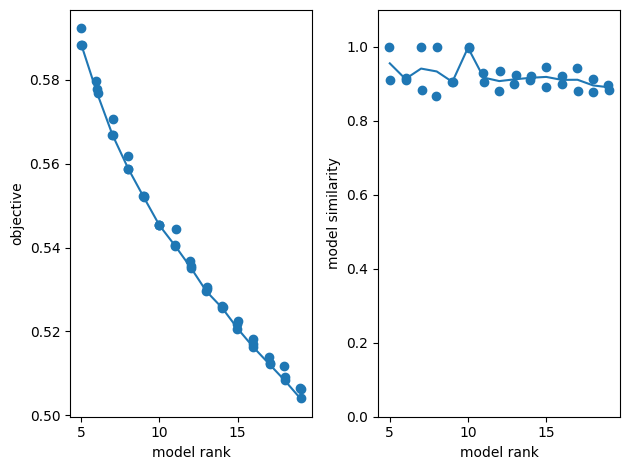

In [16]:
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(spike_matrix, ranks=range(5,20), replicates=3)

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

plt.show()

### Showing the Components
The factors for a given rank and replicate are retrived from the ensemble's `factors` method. Set `num_components` and `replicate` to be the indices you're interested from the model's various fits. **TensorTools** also has a native function for plotting the selected model called `plot_factors`. However, this is not as decorated as we would prefer for our purposes, so here is defined `plot_factors_fancy` which takes the figure and subplots from **TensorTools** and adds some extra labeling. Specifically, it display the partitioning of the neuronal factors based on their brain region, and partitioning the two main stimulus epochs from this particular experiment. It can be seen in the components plot below that, for some factors, there is differential activity of the neurons between each brain region. The same can be said for the trial factors between the first block of stimulus trials and the second block.

This given run already provide interesting insights with regards to the neuronal activity during repeats of the natural movies.
Our movie was shown in 2 blocks : Block 0 and 1, each made of successive repeats of the movie. These blocks are identified on the previous plot with a yellow dashed line. TCA identifies several components that are block specific and sometime transiently activated at the onset of the first or second block.
Certain components are evenly distributed across all trials, are non-homogenously distributed across cells (in VISp, VISl, VISpm) and show very strong transient patterns of activity. Those components could be related to specific aspects of the movie.

In [17]:
# Plot the low-d factors for an example model, e.g. rank-2, first optimization run / replicate.
num_components = 8
replicate = 0

In [18]:
def plot_factors_fancy(fig, subplots, n_neurons_in_region, stim_times, window_start_time, window_end_time, title=None, stim_borders_thresh=-1):
  # get lines separating the neurons of the selected brain regions and their midpoints for label locations
  region_bounds = np.array( [0] + [sum(n_neurons_in_region[:i+1]) for i in range(len(n_neurons_in_region))] )
  region_lines = region_bounds[1:-1]
  region_label_locs = region_bounds[:-1] + np.diff(region_bounds)/2

  # get lines separating blocks of stimulus repeats and their midpoints for label locations
  if stim_borders_thresh > 0:
    stim_diffs = np.diff(stim_times)
    stim_gaps, = np.where(stim_diffs > stim_borders_thresh*np.median(stim_diffs))
    stim_bounds = [0] + list(stim_gaps) + [len(stim_times)]
    stim_label_locs = stim_bounds[:-1] + np.diff(stim_bounds)/2
    stim_block_labels = [f"Block {i}" for i in range(len(stim_label_locs))]

  for subplot in subplots:
    # draw lines separating brain regions
    n_ymin, n_ymax = subplot[0].get_ylim()
    subplot[0].vlines(region_lines, n_ymin, n_ymax, ls=":", color="red")

    t_xmin, t_xmax = subplot[1].get_xlim()
    subplot[1].set_xticks(np.linspace(t_xmin, t_xmax, 3), labels=np.linspace(window_start_time, window_end_time, 3))

    # draw lines separating trial intervals
    if stim_borders_thresh > 0:
        ymin, ymax = subplot[2].get_ylim()
        subplot[2].vlines(stim_bounds, ymin, ymax, ls=":", color="goldenrod")

  # set tick labels for brain regions
  subplot[0].set_xticks(region_label_locs, brain_regions)
  [t.set_color("red") for t in subplot[0].xaxis.get_ticklabels()]

  # set tick labels for blocks of stimulus repeats
  if stim_borders_thresh > 0:
    subplots[-1][2].set_xticks(stim_label_locs, stim_block_labels)
    [t.set_color("goldenrod") for t in subplot[2].xaxis.get_ticklabels()]

  subplots[-1][0].set_xlabel("Neuronal")
  subplots[-1][1].set_xlabel("Temporal")
  subplots[-1][2].set_xlabel("Trial")

  fig.suptitle(title)
  fig.tight_layout()
  plt.show()

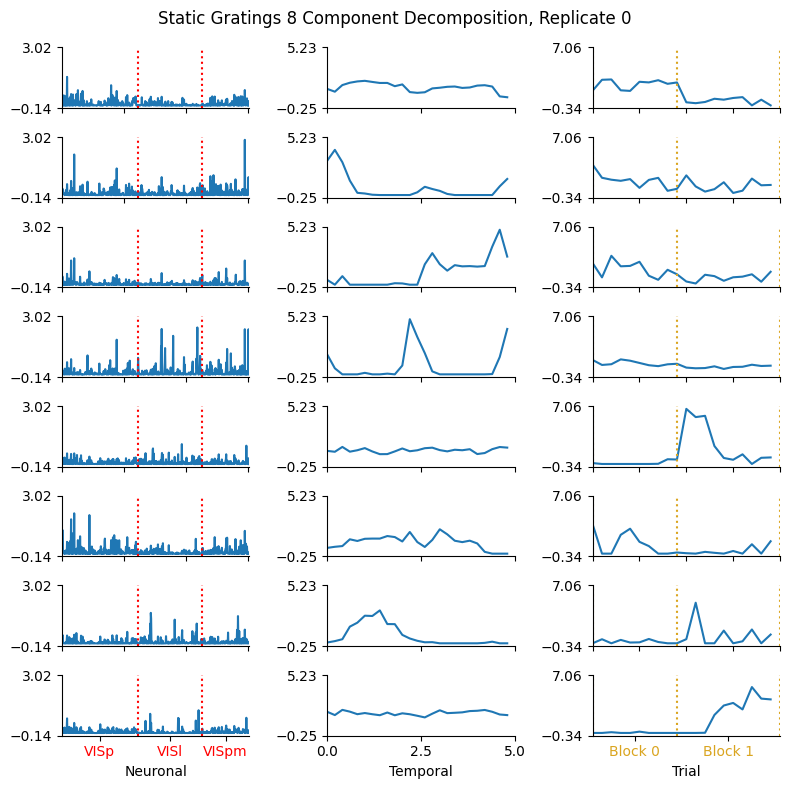

In [19]:
factor = ensemble.factors(num_components)[replicate]
fig, subplots, lines = tt.plot_factors(factor)  # plot the low-d factors
title = f"Static Gratings {num_components} Component Decomposition, Replicate {replicate}"

plot_factors_fancy(fig, subplots, n_neurons_in_region, stim_times, window_start_time, window_end_time, title=title, stim_borders_thresh=10)

### Extracting Activity
Next, we try to verify if the component representations are really reflected in the data. You can select specific components by setting `selected_components` to a list of componenent indices from the plot above. Below the real spiking activity over for all cells is shown from the spike matrix that was inputted to TCA. Below that, the selected temporal components are plotted in 2D with their respective neuronal weights to resemble the real spike counts plot. Visually, we can disentangle the various components' effect on the overall spike counts. Because different components also vary in their impact throughout trials, we also show each of the components weighted by their overall contribution to the spike counts.

In [20]:
# components of interest from the plot above
selected_components = [0,1,2,3,4,5,6,7]

In [21]:
def get_component_spike_counts(factor, component, units_spike_times):
    neuron_component = factor[0][:, component]

    # get indices of greatest 10% neurons
    frac = len(neuron_component) // 10
    max_idxs = np.argpartition(neuron_component, -frac)[-frac:]

    # subselect these units from units_spike_times
    selected_units_spike_times = units_spike_times[max_idxs]
    len(selected_units_spike_times)

    selected_spikes = get_spike_matrix(selected_units_spike_times, stim_times, bin_edges, time_resolution)
    spike_counts = np.mean(selected_spikes, axis=2)
    return spike_counts

Text(0, 0.5, 'Neuron')

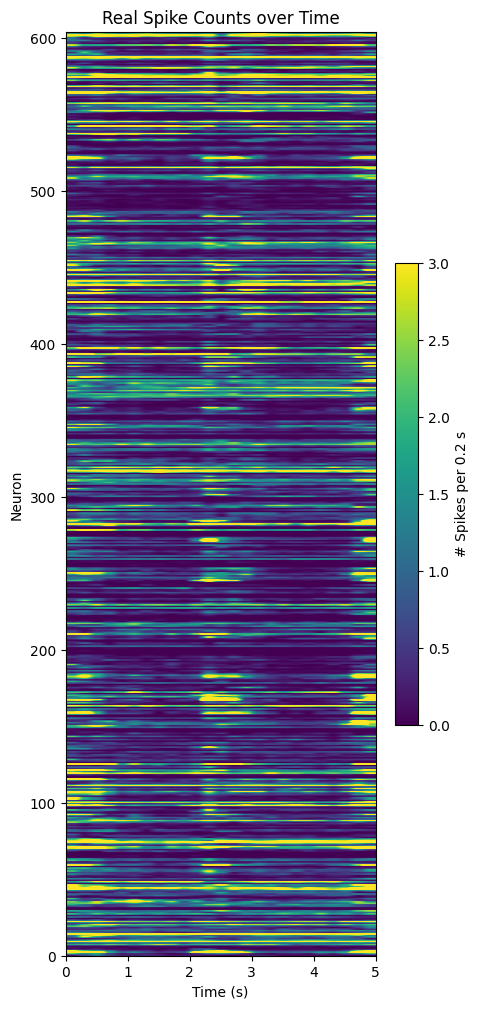

In [22]:
spike_counts = np.mean(spike_matrix, axis=2)
fig, ax = plt.subplots(figsize=(5,12))
im = ax.imshow(spike_counts, extent=[window_start_time,window_end_time,0,len(spike_counts)], aspect="auto", vmin=0, vmax=3)

cbar = fig.colorbar(im, shrink=0.5)
cbar.set_label(f"# Spikes per {time_resolution} s")

ax.set_title("Real Spike Counts over Time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Neuron")

Text(0.5, 0.98, 'Activity of 8 components')

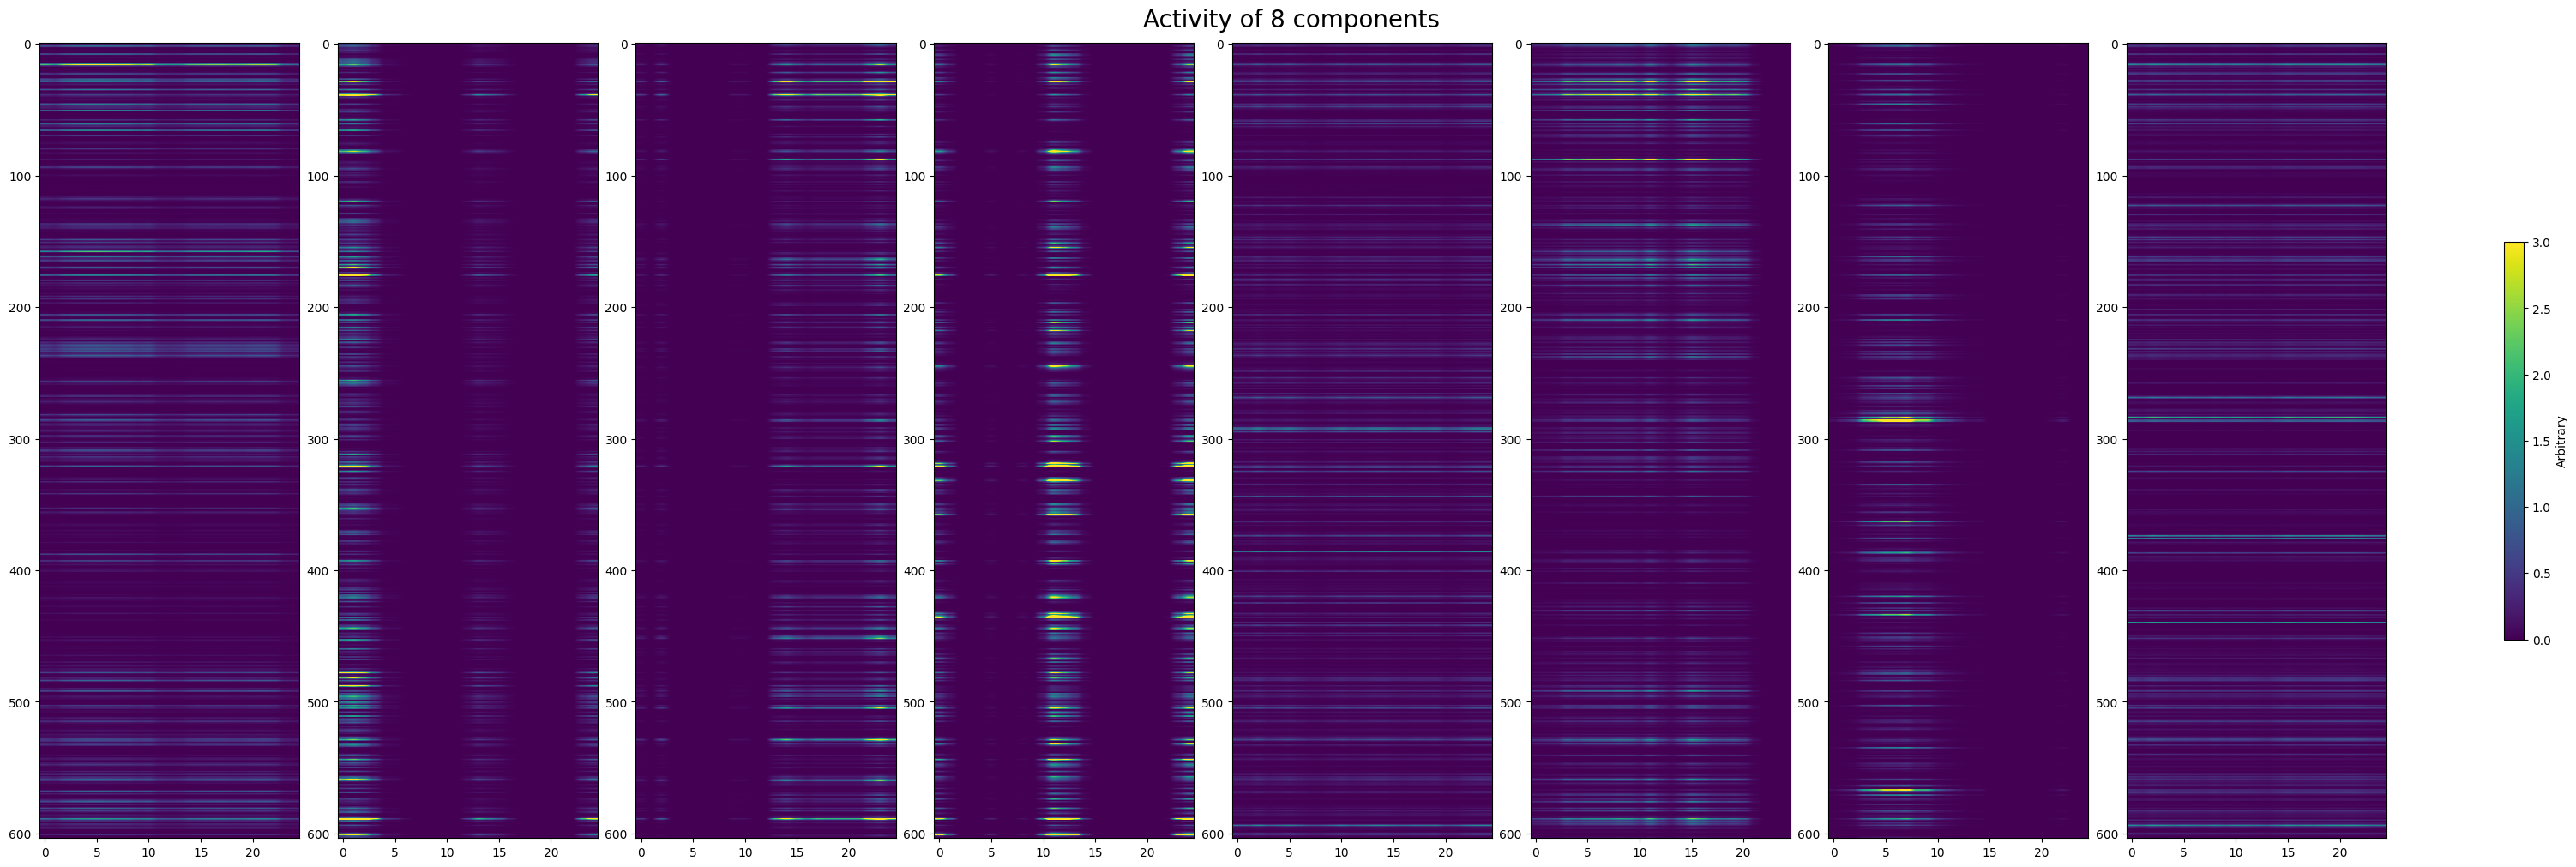

In [23]:
fig, axes = plt.subplots(1, len(selected_components), figsize=(30,10), constrained_layout=True)
for i in range(len(selected_components)):
    component_idx = selected_components[i]
    neuron_component = factor[0][:, component_idx]
    time_component = factor[1][:, component_idx]

    transformed_neuron_component = np.expand_dims(neuron_component, 1)
    neuron_weighted_time_component = time_component * transformed_neuron_component
    im = axes[i].imshow(neuron_weighted_time_component, aspect="auto", vmin=0, vmax=3)

cbar = fig.colorbar(im, ax=axes.flatten(), shrink=0.5)
cbar.set_label("Arbitrary")
fig.suptitle(f"Activity of {len(axes)} components", size=20)

Text(0.5, 0.98, 'Weighted Relative Activity of 8 components')

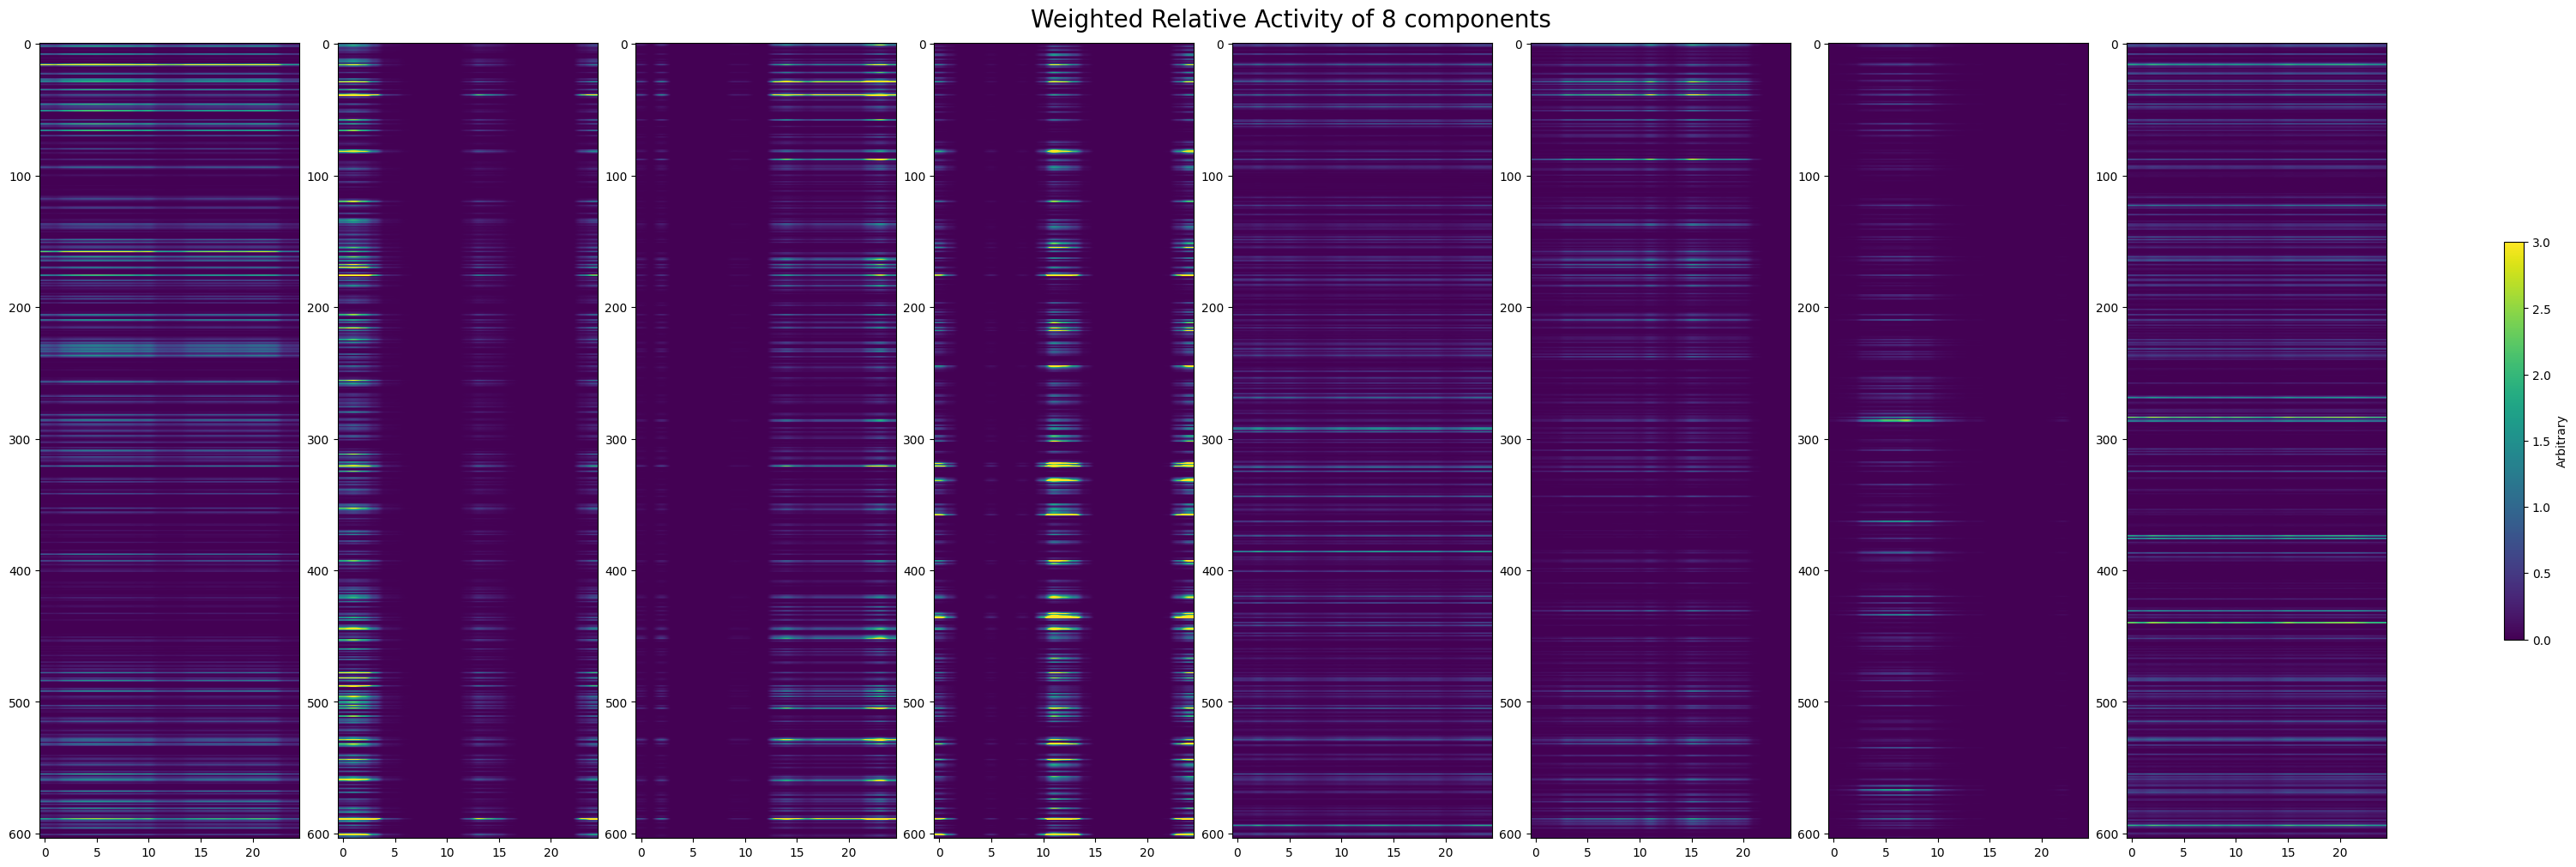

In [24]:
fig, axes = plt.subplots(1, len(selected_components), figsize=(30,10), constrained_layout=True)
for i in range(len(selected_components)):
    component_idx = selected_components[i]
    neuron_component = factor[0][:, component_idx]
    time_component = factor[1][:, component_idx]
    trial_component = factor[2][:, component_idx]

    transformed_neuron_component = np.expand_dims(neuron_component, 1)
    neuron_weighted_time_component = time_component * transformed_neuron_component
    
    trial_component_weight = np.mean(trial_component)
    trial_weighted_times = neuron_weighted_time_component * trial_component_weight
    im = axes[i].imshow(trial_weighted_times, aspect="auto", vmin=0, vmax=3)

cbar = fig.colorbar(im, ax=axes.flatten(), shrink=0.5)
cbar.set_label("Arbitrary")
fig.suptitle(f"Weighted Relative Activity of {len(axes)} components", size=20)

### Comparing Different Stimuli
TCA's performance varies. Here, we produce a spike matrix and run TCA on four different stimulus types included in this file. For comparison's sake, they all use a 0.25 second period following the selected stimulus times with a bin size of 10 ms. The stimuli used are natural movies 1, natural movies 3, gratings, and full field flashes. In the loss plot following the training, we can compare TCA's relative performance between all these stim types. This example would seem to suggest that flashes is inherently processed in a 'lower dimensional' space than the rest, followed by movie 3, movie 1 and finally gratings, which is thus the most complex. It could also be the case that different bin sizes and stim window length would be better at capturing the responses to a particular stimulus. This will depend on the speed and number of trials of the stimulus regimen used, which can be gleaned from each stimulus' respective stim table.

In [25]:
time_resolution = 0.01
window_start_time = 0
window_end_time = 0.25

In [26]:
n_bins = int((window_end_time - window_start_time) / time_resolution)
bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

In [27]:
stim_table_1 = nwb.intervals["natural_movie_one_presentations"]
stim_select_1 = lambda row: int(row.frame) == 0
stim_times_1 = [float(stim_table_1[i].start_time) for i in range(len(stim_table_1)) if stim_select_1(stim_table_1[i])]
print(len(stim_times_1))

spike_matrix_1 = get_spike_matrix(units_spike_times, stim_times_1, bin_edges, time_resolution)
print(spike_matrix_1.shape)

ensemble_1 = tt.Ensemble(fit_method="ncp_hals")
ensemble_1.fit(spike_matrix_1, ranks=range(5,20), replicates=3)

20
(604, 25, 20)


Rank-5 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 0.3s


Rank-6 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 0.4s


Rank-7 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 0.4s


Rank-8 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 0.6s


Rank-9 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 0.6s


Rank-10 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 0.5s


Rank-11 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 0.9s


Rank-12 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 0.6s


Rank-13 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 0.9s


Rank-14 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 0.9s


Rank-15 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 0.8s


Rank-16 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 1.1s


Rank-17 models:  min obj, 0.82;  max obj, 0.83;  time to fit, 2.9s


Rank-18 models:  min obj, 0.82;  max obj, 0.82;  time to fit, 2.9s


Rank-19 models:  min obj, 0.82;  max obj, 0.82;  time to fit, 3.0s


In [28]:
stim_table_2 = nwb.intervals["natural_movie_three_presentations"]
stim_select_2 = lambda row: int(row.frame) == 0
stim_times_2 = [float(stim_table_2[i].start_time) for i in range(len(stim_table_2)) if stim_select_2(stim_table_2[i])]
print(len(stim_times_2))

spike_matrix_2 = get_spike_matrix(units_spike_times, stim_times_2, bin_edges, time_resolution)
print(spike_matrix_2.shape)

ensemble_2 = tt.Ensemble(fit_method="ncp_hals")
ensemble_2.fit(spike_matrix_2, ranks=range(5,20), replicates=3)

10
(604, 25, 10)


Rank-5 models:  min obj, 0.82;  max obj, 0.82;  time to fit, 0.2s


Rank-6 models:  min obj, 0.82;  max obj, 0.82;  time to fit, 0.3s


Rank-7 models:  min obj, 0.81;  max obj, 0.82;  time to fit, 0.3s


Rank-8 models:  min obj, 0.81;  max obj, 0.81;  time to fit, 0.3s


Rank-9 models:  min obj, 0.81;  max obj, 0.81;  time to fit, 0.5s


Rank-10 models:  min obj, 0.80;  max obj, 0.80;  time to fit, 0.4s


Rank-11 models:  min obj, 0.80;  max obj, 0.80;  time to fit, 0.6s


Rank-12 models:  min obj, 0.79;  max obj, 0.79;  time to fit, 0.7s


Rank-13 models:  min obj, 0.79;  max obj, 0.79;  time to fit, 0.7s


Rank-14 models:  min obj, 0.79;  max obj, 0.79;  time to fit, 0.6s


Rank-15 models:  min obj, 0.78;  max obj, 0.78;  time to fit, 1.2s


Rank-16 models:  min obj, 0.78;  max obj, 0.78;  time to fit, 0.8s


Rank-17 models:  min obj, 0.77;  max obj, 0.77;  time to fit, 3.6s


Rank-18 models:  min obj, 0.77;  max obj, 0.77;  time to fit, 3.2s


Rank-19 models:  min obj, 0.77;  max obj, 0.77;  time to fit, 4.2s


In [29]:
stim_table_3 = nwb.intervals["static_gratings_presentations"]
stim_select_3 = lambda row: float(row.orientation) == 90.0 and float(row.phase) == 0.5
stim_times_3 = [float(stim_table_3[i].start_time) for i in range(len(stim_table_3)) if stim_select_3(stim_table_3[i])]
print(len(stim_times_3))

spike_matrix_3 = get_spike_matrix(units_spike_times, stim_times_3, bin_edges, time_resolution)
print(spike_matrix_3.shape)

ensemble_3 = tt.Ensemble(fit_method="ncp_hals")
ensemble_3.fit(spike_matrix_3, ranks=range(5,20), replicates=3)

244
(604, 25, 244)


Rank-5 models:  min obj, 0.92;  max obj, 0.92;  time to fit, 2.2s


Rank-6 models:  min obj, 0.92;  max obj, 0.92;  time to fit, 2.4s


Rank-7 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 1.9s


Rank-8 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 3.0s


Rank-9 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 2.4s


Rank-10 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 2.8s


Rank-11 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 2.6s


Rank-12 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 3.0s


Rank-13 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 3.0s


Rank-14 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 3.4s


Rank-15 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 2.6s


Rank-16 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 4.5s


Rank-17 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 4.8s


Rank-18 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 6.6s


Rank-19 models:  min obj, 0.89;  max obj, 0.90;  time to fit, 5.1s


In [30]:
stim_table_4 = nwb.intervals["flashes_presentations"]
stim_times_4 = []
for i in range(len(stim_table_4)):
    if i == len(stim_table_4)-2:
        break
    if float(stim_table_4[i].color) == -1 and float(stim_table_4[i+1].color) == 1:
        stim_times_4.append(stim_table_4[i].stop_time.item())
stim_times_4 = stim_times_4[:20]

print(len(stim_times_4))

spike_matrix_4 = get_spike_matrix(units_spike_times, stim_times_4, bin_edges, time_resolution)
print(spike_matrix_4.shape)

ensemble_4 = tt.Ensemble(fit_method="ncp_hals")
ensemble_4.fit(spike_matrix_4, ranks=range(5,20), replicates=3)

20
(604, 25, 20)


Rank-5 models:  min obj, 0.80;  max obj, 0.80;  time to fit, 0.3s


Rank-6 models:  min obj, 0.80;  max obj, 0.80;  time to fit, 0.4s


Rank-7 models:  min obj, 0.79;  max obj, 0.79;  time to fit, 0.5s


Rank-8 models:  min obj, 0.78;  max obj, 0.78;  time to fit, 0.6s


Rank-9 models:  min obj, 0.78;  max obj, 0.78;  time to fit, 0.5s


Rank-10 models:  min obj, 0.77;  max obj, 0.77;  time to fit, 0.7s


Rank-11 models:  min obj, 0.77;  max obj, 0.77;  time to fit, 0.6s


Rank-12 models:  min obj, 0.76;  max obj, 0.77;  time to fit, 0.9s


Rank-13 models:  min obj, 0.76;  max obj, 0.76;  time to fit, 1.1s


Rank-14 models:  min obj, 0.76;  max obj, 0.76;  time to fit, 0.7s


Rank-15 models:  min obj, 0.75;  max obj, 0.76;  time to fit, 0.9s


Rank-16 models:  min obj, 0.75;  max obj, 0.75;  time to fit, 1.6s


Rank-17 models:  min obj, 0.74;  max obj, 0.75;  time to fit, 2.7s


Rank-18 models:  min obj, 0.74;  max obj, 0.75;  time to fit, 2.7s


Rank-19 models:  min obj, 0.74;  max obj, 0.74;  time to fit, 3.1s


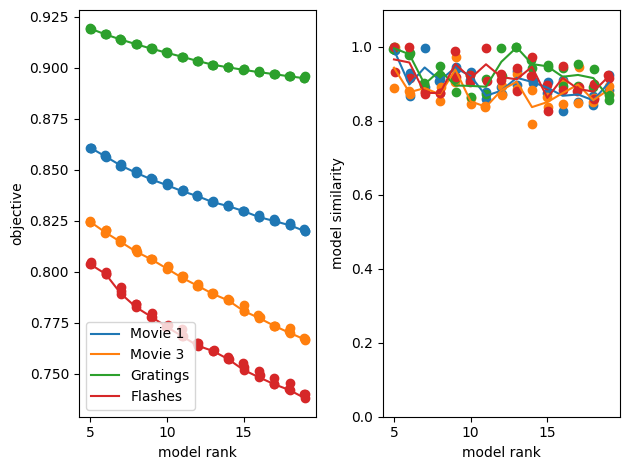

In [31]:
fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble_1, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_objective(ensemble_2, ax=axes[0])
tt.plot_objective(ensemble_3, ax=axes[0])
tt.plot_objective(ensemble_4, ax=axes[0])

tt.plot_similarity(ensemble_1, ax=axes[1])  # plot model similarity as a function of num components.
tt.plot_similarity(ensemble_2, ax=axes[1])
tt.plot_similarity(ensemble_3, ax=axes[1])
tt.plot_similarity(ensemble_4, ax=axes[1])

lines = axes[0].lines
axes[0].legend(lines, ["Movie 1","Movie 3","Gratings","Flashes"])

fig.tight_layout()
plt.show()